In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import sys
import os

# Add project root to Python path
project_root = Path.cwd().parent  # Go up one level from src to project root
sys.path.append(str(project_root))

# Now we can import from config
from config.const import DEFAULT_TARGET_FEATURE

# Debug: Print current working directory
print("Current working directory:", os.getcwd())

# Get all monthly train and test files separately
# Use Path to handle paths correctly
data_dir = project_root / "data" / "output" / "preprocessed"
train_files = list(data_dir.glob("*_train.csv"))
test_files = list(data_dir.glob("*_test.csv"))

# Sort files by month
train_files.sort()
test_files.sort()

print(train_files)

print("\nTrain files found:", len(train_files))
print("Test files found:", len(test_files))

# Function to load and prepare monthly data
def load_monthly_data(file_path):
    """Load data for a specific month and select relevant columns."""
    df = pd.read_csv(file_path)
    return df

# Load train data
train_data = {}
for file in train_files:
    month = file.stem.split('_')[-2]  # Extract month number
    df = load_monthly_data(file)
    train_data[month] = df
    print(f"Loaded train data for month {month} with shape {df.shape}")

# Load test data
test_data = {}
for file in test_files:
    month = file.stem.split('_')[-2]  # Extract month number
    df = load_monthly_data(file)
    test_data[month] = df
    print(f"Loaded test data for month {month} with shape {df.shape}")

# Create combined dataframes for train and test
train_combined = pd.concat(
    [df.assign(month=month) for month, df in train_data.items()],
    ignore_index=True
)

test_combined = pd.concat(
    [df.assign(month=month) for month, df in test_data.items()],
    ignore_index=True
)

# Months as integer
train_combined['month'] = train_combined['month'].astype(int)
test_combined['month'] = test_combined['month'].astype(int)

# # Convert and save trainDelayed as 0/1 : True: 1, False: 0
# train_combined['trainDelayed'] = train_combined['trainDelayed'].map({True: 1, False: 0})
# test_combined['trainDelayed'] = test_combined['trainDelayed'].map({True: 1, False: 0})

print("\nCombined data shapes:")
print(f"Train data: {train_combined.shape}")
print(f"Test data: {test_combined.shape}")
train_combined.head(10)

print("Training Set Data Types:")
print(train_combined.dtypes)


Current working directory: d:\Oulu MSc\Summer Internship 2025\Railway-FMI-Data_training\src
[WindowsPath('d:/Oulu MSc/Summer Internship 2025/Railway-FMI-Data_training/data/output/preprocessed/preprocessed_data_2020-2024_12_train.csv')]

Train files found: 1
Test files found: 1
Loaded train data for month 12 with shape (161611, 13)
Loaded test data for month 12 with shape (69263, 13)

Combined data shapes:
Train data: (161611, 14)
Test data: (69263, 14)
Training Set Data Types:
Air temperature            float64
Wind speed                 float64
Gust speed                 float64
Wind direction             float64
Relative humidity          float64
Dew-point temperature      float64
Precipitation intensity    float64
Snow depth                 float64
Pressure (msl)             float64
Horizontal visibility      float64
Cloud amount               float64
data_year                    int64
differenceInMinutes        float64
month                        int64
dtype: object


In [3]:

def check_missing_data_info(df, p_fig=True):
    """
    Returns missing data info and a heatmap figure for the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to check for missing data.
        
    Returns:
        missing_info (pd.DataFrame): DataFrame with columns ['Column', 'Missing Count', 'Missing %'].
    """
    # Calculate missing data info
    missing_counts = df.isnull().sum()
    missing_percents = (missing_counts / len(df)) * 100
    missing_info = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing Count': missing_counts.values,
        'Missing %': missing_percents.values
    })
    
    if p_fig == True: 
        # Create the heatmap figure
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap='viridis', ax=ax)
        ax.set_title('Missing Values Heatmap')
        plt.show(fig)
    
    return missing_info

missing_info_train = check_missing_data_info(train_combined, p_fig=False)
print(f'{missing_info_train}\n')

missing_info_test = check_missing_data_info(test_combined, p_fig=False)
print(f'{missing_info_test}\n')

                     Column  Missing Count  Missing %
0           Air temperature              0        0.0
1                Wind speed              0        0.0
2                Gust speed              0        0.0
3            Wind direction              0        0.0
4         Relative humidity              0        0.0
5     Dew-point temperature              0        0.0
6   Precipitation intensity              0        0.0
7                Snow depth              0        0.0
8            Pressure (msl)              0        0.0
9     Horizontal visibility              0        0.0
10             Cloud amount              0        0.0
11                data_year              0        0.0
12      differenceInMinutes              0        0.0
13                    month              0        0.0

                     Column  Missing Count  Missing %
0           Air temperature              0        0.0
1                Wind speed              0        0.0
2                Gust speed

Class Distribution in Training Set:
trainDelayed
0    169595
1      2127
Name: count, dtype: int64

Percentage of Classes in Training Set:
trainDelayed
0    98.76
1     1.24
Name: count, dtype: float64


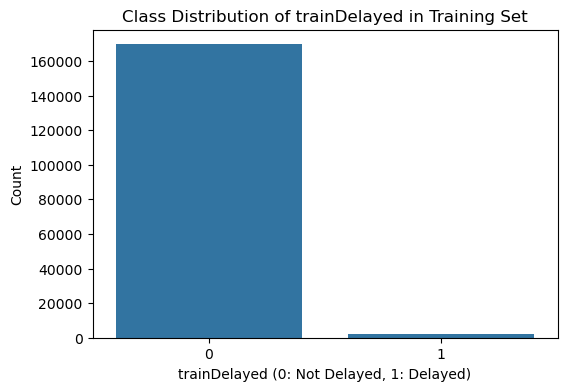

In [5]:
# Check class distribution in Training set

# temp_df = pd.read_csv('d:/Oulu MSc/Summer Internship 2025/Railway-FMI-Data_training/data/output/preprocessed/preprocessed_data_2020-2024_01_train.csv')
# temp_df.head()

# print(temp_df['trainDelayed'].value_counts())
print("Class Distribution in Training Set:")
print(train_combined['trainDelayed'].value_counts())
print("\nPercentage of Classes in Training Set:")
print((train_combined['trainDelayed'].value_counts() / len(train_combined) * 100).round(2))

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='trainDelayed', data=train_combined)
plt.title('Class Distribution of trainDelayed in Training Set')
plt.xlabel('trainDelayed (0: Not Delayed, 1: Delayed)')
plt.ylabel('Count')
plt.show()

In [8]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve

# Features and target
X_train = train_combined[
        [
        'Snow depth'
        ,'Air temperature'
        ,'Wind speed'
        ,'Gust speed'
        ,'Wind direction'
        ,'Relative humidity'
        ,'Dew-point temperature'
        ,'Precipitation amount'
        ,'Precipitation intensity'
        ,'Pressure (msl)'
        ,'Horizontal visibility'
        ,'Cloud amount' 
        ]
    ]
y_train = train_combined['trainDelayed']

X_test = test_combined[
        [
        'Snow depth'
        ,'Air temperature'
        ,'Wind speed'
        ,'Gust speed'
        ,'Wind direction'
        ,'Relative humidity'
        ,'Dew-point temperature'
        ,'Precipitation amount'
        ,'Precipitation intensity'
        ,'Pressure (msl)'
        ,'Horizontal visibility'
        ,'Cloud amount' 
        ]
    ]
y_test = test_combined['trainDelayed']

brf_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf_classifier.fit(X_train, y_train)
y_pred_brf = brf_classifier.predict(X_test)
y_prob_brf = brf_classifier.predict_proba(X_test)[:, 1]

print("F1-Score:", f1_score(y_test, y_pred_brf))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_brf))
print("AUPRC:", average_precision_score(y_test, y_prob_brf))

F1-Score: 0.039488279227981954
AUC-ROC: 0.6315454557192982
AUPRC: 0.019933396529607107


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Temporary dataset without missing values for importance check
X_temp = temp_data.drop('trainDelayed', axis=1)
y_temp = temp_data['trainDelayed']

# Fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_temp, y_temp)

# Feature importance
importance = pd.Series(rf.feature_importances_, index=X_temp.columns).sort_values(ascending=False)
print("Feature Importance:\n", importance)

Feature Importance:
 Relative humidity          0.102506
Pressure (msl)             0.097330
Wind speed                 0.093702
Cloud amount               0.092776
Wind direction             0.089856
Air temperature            0.086342
Horizontal visibility      0.086313
Gust speed                 0.083292
Dew-point temperature      0.082666
Snow depth                 0.077851
data_year                  0.031991
Precipitation intensity    0.027683
Precipitation amount       0.024239
month                      0.023453
dtype: float64


In [18]:
from config.const import (
    XGBOOST_DEFAULT_PARAMS,
    RANDOMIZED_SEARCH_PARAM_DISTRIBUTIONS,
    MAX_SAMPLE_WEIGHT_CLASSIFICATION
)

# Air temperature,
# Wind speed,
# Gust speed,
# Wind direction,
# Relative humidity,
# Dew-point temperature,
# Precipitation amount,
# Precipitation intensity,
# Snow depth,
# Pressure (msl), 
# Horizontal visibility,
# Cloud amount,
# data_year,
# trainDelayed
# month

# Features and target
X_train = train_combined[
        [
        'Snow depth'
        # ,'Air temperature'
        # ,'Wind speed'
        # ,'Gust speed'
        # ,'Wind direction'
        # ,'Relative humidity'
        # ,'Dew-point temperature'
        # ,'Precipitation amount'
        # ,'Precipitation intensity'
        # ,'Pressure (msl)'
        # ,'Horizontal visibility'
        # ,'Cloud amount' 
        ]
    ]
y_train = train_combined['trainDelayed']

X_test = test_combined[
        [
        'Snow depth'
        # ,'Air temperature'
        # ,'Wind speed'
        # ,'Gust speed'
        # ,'Wind direction'
        # ,'Relative humidity'
        # ,'Dew-point temperature'
        # ,'Precipitation amount'
        # ,'Precipitation intensity'
        # ,'Pressure (msl)'
        # ,'Horizontal visibility'
        # ,'Cloud amount' 
        ]
    ]
y_test = test_combined['trainDelayed']

ImportError: cannot import name 'XGBOOST_DEFAULT_PARAMS' from 'config.const' (d:\Oulu MSc\Summer Internship 2025\Railway-FMI-Data_training\config\const.py)

In [43]:
import xgboost as xgb
from sklearn.metrics import classification_report

params = XGBOOST_DEFAULT_PARAMS.copy()
params['random_state'] = 42

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57    229390
           1       0.54      0.45      0.49    228912

    accuracy                           0.53    458302
   macro avg       0.53      0.53      0.53    458302
weighted avg       0.53      0.53      0.53    458302



In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression F1-Score:", f1_score(y_test, y_pred_lr))

Logistic Regression F1-Score: 0.4217594197488067


In [30]:
# Example: Collect metrics after model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# y_test and y_pred are your true and predicted labels
metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'weighted_avg_f1': f1_score(y_test, y_pred_xgb, average='weighted'),
    'macro_avg_f1': f1_score(y_test, y_pred_xgb, average='macro'),
    'class_False_f1': f1_score(y_test, y_pred_xgb, pos_label=0),
    'class_False_precision': precision_score(y_test, y_pred_xgb, pos_label=0),
    'class_False_recall': recall_score(y_test, y_pred_xgb, pos_label=0),
    'class_True_f1': f1_score(y_test, y_pred_xgb, pos_label=1),
    'class_True_precision': precision_score(y_test, y_pred_xgb, pos_label=1),
    'class_True_recall': recall_score(y_test, y_pred_xgb, pos_label=1),
}

# Convert to DataFrame (one row)
metrics_df = pd.DataFrame([metrics])
metrics_df.head()

# Save to CSV
metrics_df.to_csv('my_model_metrics.csv', index=False)

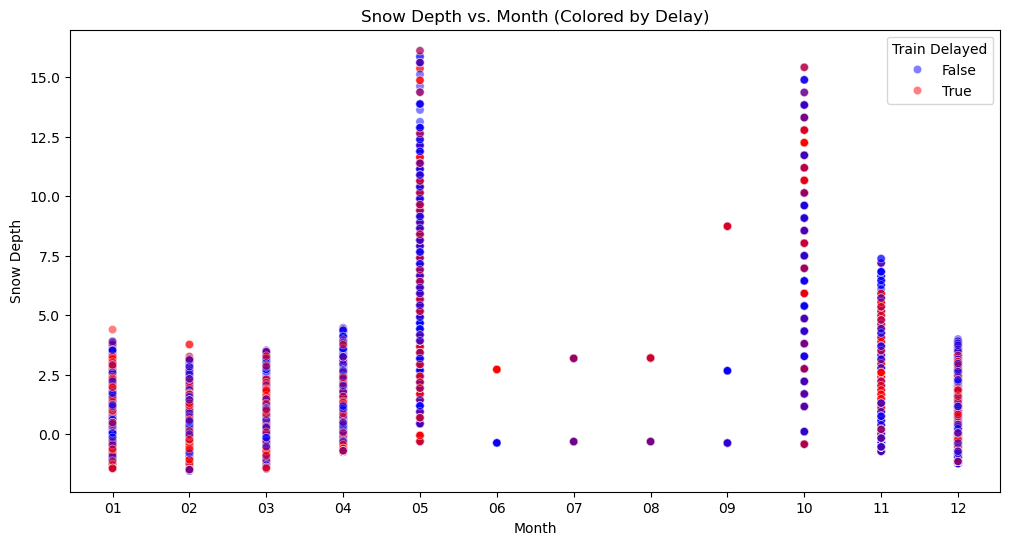

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=train_combined, 
    x='month', 
    y='Snow depth', 
    hue='trainDelayed', 
    palette={0: 'blue', 1: 'red'}, 
    alpha=0.5
)
plt.title('Snow Depth vs. Month (Colored by Delay)')
plt.xlabel('Month')
plt.ylabel('Snow Depth')
plt.legend(title='Train Delayed')
plt.show()

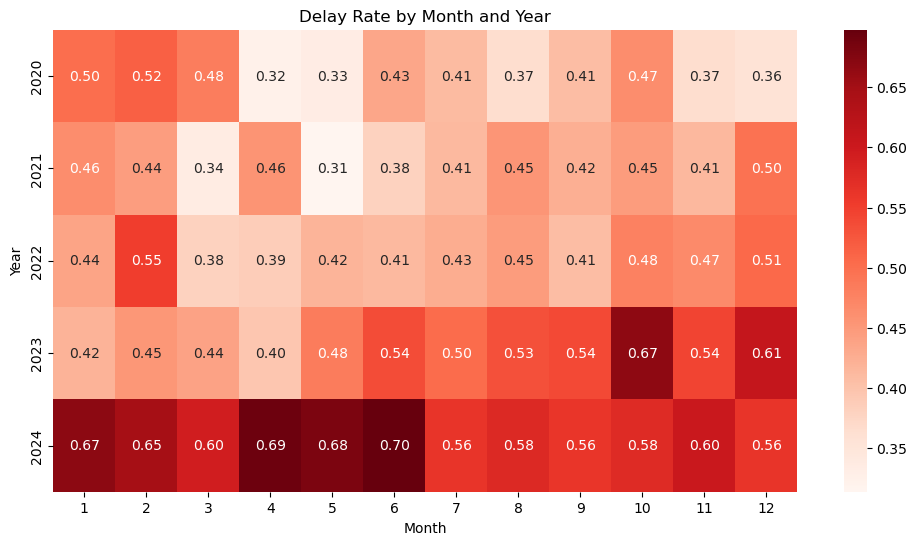

In [31]:

# Ensure month is string or categorical for proper heatmap ordering
# train_combined['month'] = train_combined['month'].astype(str)

# Create a pivot table: rows = data_year, columns = month, values = mean delay rate
delay_pivot = train_combined.pivot_table(
    index='data_year',
    columns='month',
    values='trainDelayed',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(delay_pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title('Delay Rate by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

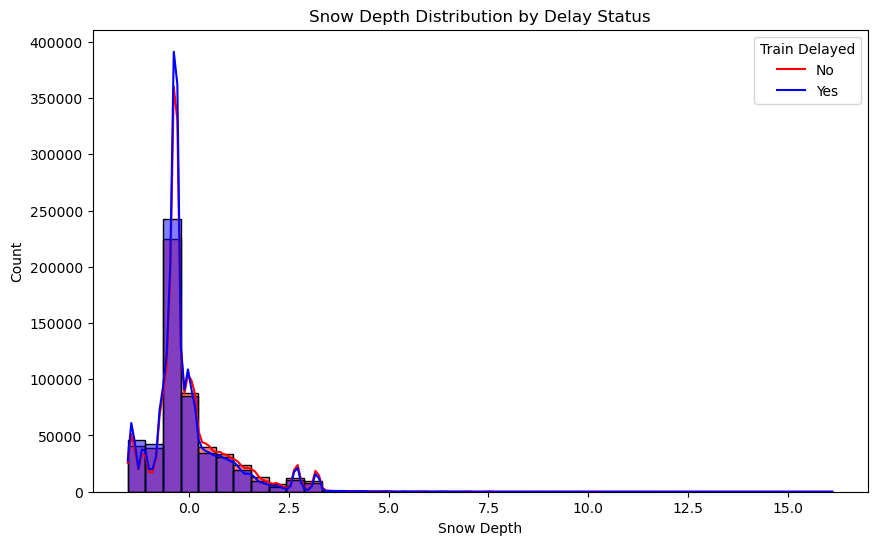

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=train_combined,
    x='Snow depth',
    hue='trainDelayed',
    bins=40,
    kde=True,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)
plt.title('Snow Depth Distribution by Delay Status')
plt.xlabel('Snow Depth')
plt.ylabel('Count')
plt.legend(title='Train Delayed', labels=['No', 'Yes'])
plt.show()

In [16]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test) > 0.5
print("Lasso Classification Report:")
print(classification_report(y_test, y_pred_lasso))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test) > 0.5
print("Ridge Classification Report:")
print(classification_report(y_test, y_pred_ridge))

Lasso Classification Report:


c:\Users\usama\miniconda3\envs\venv_rail_fmi_training\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\usama\miniconda3\envs\venv_rail_fmi_training\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\usama\miniconda3\envs\venv_rail_fmi_training\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

       False       0.50      1.00      0.67    229390
        True       0.00      0.00      0.00    228912

    accuracy                           0.50    458302
   macro avg       0.25      0.50      0.33    458302
weighted avg       0.25      0.50      0.33    458302

Ridge Classification Report:
              precision    recall  f1-score   support

       False       0.52      0.71      0.60    229390
        True       0.54      0.34      0.42    228912

    accuracy                           0.53    458302
   macro avg       0.53      0.53      0.51    458302
weighted avg       0.53      0.53      0.51    458302



In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_params = {k: v for k, v in RANDOMIZED_SEARCH_PARAM_DISTRIBUTIONS.items() if k in ['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion']}
dt_params = {k: v[0] if isinstance(v, list) else v for k, v in dt_params.items()}  # Use first value if list

# print (dt_params)
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, criterion='gini', random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

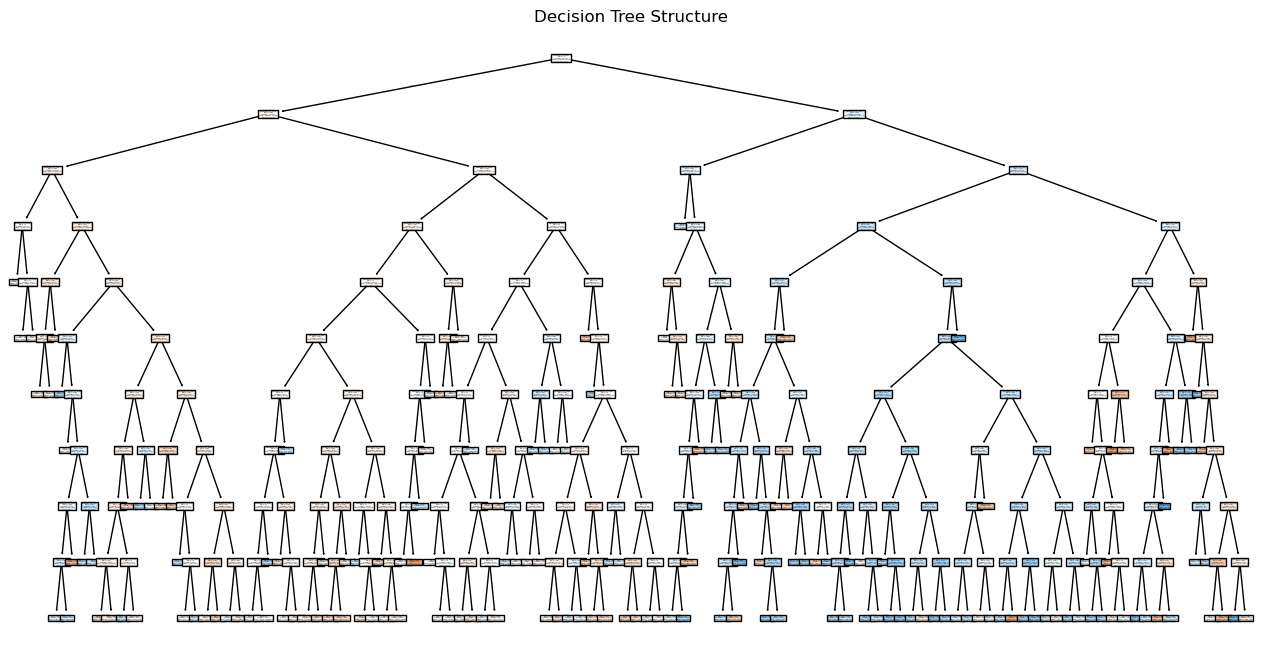

In [25]:
from sklearn import tree

plt.figure(figsize=(16, 8))
tree.plot_tree(dt, feature_names=['Snow depth'], class_names=['Not Delayed', 'Delayed'], filled=True)
plt.title('Decision Tree Structure')
plt.show()

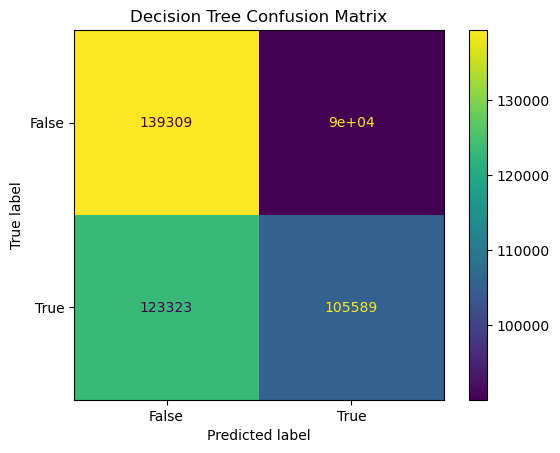

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
def train_xgboost(self, month_id, params=None, random_state=42):
        """
        Train an XGBoost model (classifier or regressor) on the preprocessed and split month data.
        For regression tasks, uses multiple approaches to ensure good R² performance.
        Now includes SHAP analysis for enhanced model interpretability.
        
        Parameters:
        -----------
        month_id : str
            Month identifier in format "YYYY-YYYY_MM" for the filename.
        params : dict, optional
            Parameters for XGBoost model. If None, default parameters are used.
        random_state : int, optional
            Random seed for reproducibility. Defaults to 42.
                
        Returns:
        --------
        dict
            A summary of the training results, including model performance metrics.
        """
        try:
            # Use default parameters if none provided
            if params is None:
                from config.const import XGBOOST_DEFAULT_PARAMS
                params = XGBOOST_DEFAULT_PARAMS.copy()
            else:
                params = params.copy()
            
            # Add random state to params
            params['random_state'] = random_state
            
            # Construct file paths for the train and test sets
            train_filename = f"{DATA_FILE_PREFIX_FOR_TRAINING}{month_id}_train.csv"
            test_filename = f"{DATA_FILE_PREFIX_FOR_TRAINING}{month_id}_test.csv"
            
            train_path = os.path.join(self.preprocessed_dir, train_filename)
            test_path = os.path.join(self.preprocessed_dir, test_filename)
            
            # Check if files exist
            if not os.path.exists(train_path) or not os.path.exists(test_path):
                error_msg = f"Files not found: {train_path} or {test_path}"
                print(f"Error: {error_msg}")
                return {"success": False, "error": error_msg}
            
            # Load datasets
            print(f"Loading training data from {train_path}")
            train_df = pd.read_csv(train_path)
            
            print(f"Loading test data from {test_path}")
            test_df = pd.read_csv(test_path)
            
            # Identify target column 
            target_options = ['differenceInMinutes', 'trainDelayed', 'cancelled', 'differenceInMinutes_offset']
            target_column = None
            
            for option in target_options:
                if option in train_df.columns:
                    target_column = option
                    break
            
            if not target_column:
                print(f"Error: No target column found in dataset")
                return {"success": False, "error": "No target column found in dataset"}
            
            print(f"Identified target column: {target_column}")
            
            # Split features and target
            X_train = train_df.drop(target_column, axis=1)
            y_train = train_df[target_column]
            
            X_test = test_df.drop(target_column, axis=1)
            y_test = test_df[target_column]

            # Drop the data_year column if it exists
            for col in ['data_year']:
                if col in X_train.columns:
                    print(f"Dropping '{col}' column from training features")
                    X_train = X_train.drop(col, axis=1)
                    
                if col in X_test.columns:
                    print(f"Dropping '{col}' column from test features")
                    X_test = X_test.drop(col, axis=1)
            
            # Create output directory
            xgboost_dir = os.path.join(self.project_root, XGBOOST_OUTPUT_FOLDER)
            os.makedirs(xgboost_dir, exist_ok=True)
            
            # Determine if it's a regression or classification problem
            is_regression = (target_column in ['differenceInMinutes', 'differenceInMinutes_offset'])
            
            if is_regression:
                # REGRESSION CASE
                print(f"Target '{target_column}' indicates a regression problem")
                
                # Create DMatrix for lower-level XGBoost API
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)
                
                # Set up regularization parameters
                xgb_params = {
                    'max_depth': params.get('max_depth', 6),
                    'eta': params.get('learning_rate', 0.1),
                    'subsample': params.get('subsample', 0.8),
                    'colsample_bytree': params.get('colsample_bytree', 0.8),
                    'seed': random_state,
                    'alpha': 0.5,  # L1 regularization to prevent overfitting
                    'lambda': 1.0,  # L2 regularization to prevent overfitting
                }
                
                # Define multiple models to train and compare
                models_to_try = []
                
                # 1. Standard regression model
                standard_params = xgb_params.copy()
                standard_params['objective'] = 'reg:squarederror'
                models_to_try.append({
                    'name': 'standard',
                    'params': standard_params, 
                    'obj': None
                })
                
                # 2. Modified custom loss function with more stable gradients
                def stable_weighted_mse(y_pred, dtrain):
                    y_true = dtrain.get_label()
                    # UPDATED: Use constant from config instead of hardcoded value
                    weights = np.minimum(MAX_SAMPLE_WEIGHT_REGRESSION, 1.0 + np.abs(y_true) / (np.abs(y_true).mean() * 2))
                    # More stable gradient calculation
                    grad = weights * (y_pred - y_true)
                    hess = weights
                    return grad, hess
                
                models_to_try.append({
                    'name': 'weighted',
                    'params': xgb_params.copy(),
                    'obj': stable_weighted_mse
                })
                
                # 3. Quantile regression - focuses on larger values without custom function
                quantile_params = xgb_params.copy()
                quantile_params['objective'] = 'reg:quantileerror'
                quantile_params['quantile_alpha'] = 0.7  # Focus on upper 70% of delay distribution
                models_to_try.append({
                    'name': 'quantile',
                    'params': quantile_params,
                    'obj': None
                })
                
                # Train and evaluate each model
                best_model = None
                best_r2 = float('-inf')
                best_metrics = None
                best_y_pred = None
                
                for model_config in models_to_try:
                    model_name = model_config['name']
                    model_params = model_config['params']
                    model_obj = model_config['obj']
                    
                    print(f"\nTraining XGBoost Regressor ({model_name} approach)...")
                    
                    # Train model
                    if model_obj:
                        xgb_model = xgb.train(
                            model_params, 
                            dtrain,
                            num_boost_round=params.get('n_estimators', 100),
                            obj=model_obj,
                            evals=[(dtrain, 'train'), (dtest, 'test')],
                            verbose_eval=10
                        )
                    else:
                        xgb_model = xgb.train(
                            model_params,
                            dtrain,
                            num_boost_round=params.get('n_estimators', 100),
                            evals=[(dtrain, 'train'), (dtest, 'test')],
                            verbose_eval=10
                        )
                    
                    # Make predictions
                    y_pred = xgb_model.predict(dtest)
                    
                    # Calculate regression metrics
                    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)
                    
                    # Calculate performance on large delays
                    large_delay_idx = np.where(np.abs(y_test) > np.abs(y_test).mean())[0]
                    large_metrics = {}
                    if len(large_delay_idx) > 0:
                        large_y_test = y_test.iloc[large_delay_idx]
                        large_y_pred = y_pred[large_delay_idx]
                        large_mse = mean_squared_error(large_y_test, large_y_pred)
                        large_rmse = np.sqrt(large_mse)
                        large_mae = mean_absolute_error(large_y_test, large_y_pred)
                        large_metrics = {
                            'large_delay_rmse': large_rmse,
                            'large_delay_mae': large_mae
                        }
                    
                    # Combine metrics
                    metrics = {
                        'mse': mse,
                        'rmse': rmse,
                        'mae': mae,
                        'r2': r2,
                        **large_metrics
                    }
                    
                    # Print metrics
                    print(f"\nXGBoost {model_name} Regressor Results:")
                    print(f"RMSE: {rmse:.4f}")
                    print(f"MAE: {mae:.4f}")
                    print(f"R²: {r2:.4f}")
                    
                    if large_metrics:
                        print(f"Large Delay RMSE: {large_metrics['large_delay_rmse']:.4f}")
                        print(f"Large Delay MAE: {large_metrics['large_delay_mae']:.4f}")
                    
                    # Keep track of best model by R² score
                    if r2 > best_r2:
                        best_r2 = r2
                        best_model = xgb_model
                        best_metrics = metrics
                        best_y_pred = y_pred
                        best_name = model_name
                
                # Use the best model
                xgb_model = best_model
                metrics = best_metrics
                y_pred = best_y_pred
                
                print(f"\nSelected best model: {best_name} (R² = {best_r2:.4f})")
                
                # Save metrics
                metrics_filename = f"model_metrics_{month_id}_best.csv"
                metrics_path = os.path.join(xgboost_dir, metrics_filename)
                pd.DataFrame([metrics]).to_csv(metrics_path, index=False)
                print(f"Model metrics saved to {metrics_path}")
                
                # Set metrics_result for consistent return
                metrics_result = {
                    "metrics": metrics,
                    "metrics_path": metrics_path
                }
                
                # Create summary result
                result = {
                    "success": True,
                    "model_type": "regression",
                    "rmse": metrics['rmse'],
                    "mae": metrics['mae'],
                    "r2": metrics['r2'],
                    "best_approach": best_name
                }
                
                # Get feature importance and normalize it
                importance_scores = xgb_model.get_score(importance_type='gain')
                
                # Normalize the importance scores to sum to 1.0
                total_importance = sum(importance_scores.values())
                normalized_scores = {k: v/total_importance for k, v in importance_scores.items()}
                
                feature_importance = pd.DataFrame({
                    'Feature': normalized_scores.keys(),
                    'Importance': normalized_scores.values()
                }).sort_values(by='Importance', ascending=False)
                
                # ========== NEW: ADD SHAP ANALYSIS FOR REGRESSION ==========
                print("\nPerforming SHAP analysis on the best XGBoost regression model...")
                
                shap_result = self.analyze_model_with_shap(
                    model=xgb_model,
                    X_test=X_test,
                    y_test=y_test,
                    model_type='regression',
                    month_id=month_id,
                    output_dir=xgboost_dir,
                    target_column=target_column,
                    max_samples=1000,
                    random_state=random_state,
                    model_name=f"xgboost_{best_name}",
                    baseline_data=train_df  # Use training data for better baseline calculation
                )
                
                if shap_result.get("success", False):
                    print("SHAP analysis completed successfully for XGBoost regression model!")
                    
                    # Compare with standard importance if SHAP was successful
                    if "shap_importance_path" in shap_result:
                        print("\n" + "-"*60)
                        print("COMPARISON: Standard vs SHAP Feature Importance (XGBoost Regression)")
                        print("-"*60)
                        
                        try:
                            # Load SHAP importance for comparison
                            shap_importance = pd.read_csv(shap_result["shap_importance_path"])
                            
                            # Merge the two importance measures
                            comparison = feature_importance.merge(
                                shap_importance[['Feature', 'SHAP_Importance_Abs', 'SHAP_Importance_Signed', 'Relative_Contribution_Pct']], 
                                on='Feature', how='left'
                            )
                            
                            print("Top 10 features by Standard Importance vs SHAP Importance:")
                            for _, row in comparison.head(10).iterrows():
                                direction = "↑" if row['SHAP_Importance_Signed'] > 0 else "↓"
                                shap_abs = row['SHAP_Importance_Abs'] if pd.notna(row['SHAP_Importance_Abs']) else 0
                                rel_contrib = row['Relative_Contribution_Pct'] if pd.notna(row['Relative_Contribution_Pct']) else 0
                                print(f"{row['Feature']:<25}: Standard={row['Importance']:>6.4f}, "
                                    f"SHAP={shap_abs:>8.4f} {direction}, "
                                    f"({rel_contrib:>4.1f}% of impact)")
                        except Exception as e:
                            print(f"Could not perform comparison: {e}")
                    
                else:
                    print(f"SHAP analysis failed: {shap_result.get('error', 'Unknown error')}")
                
                print("="*60)
                            
            else:
                # CLASSIFICATION CASE
                print(f"Target '{target_column}' indicates a classification problem")
                print("Training XGBoost Classifier")
                
                # Set classification parameters
                if target_column == 'trainDelayed':
                    params['objective'] = 'binary:logistic'
                    print("Using binary classification")
                else:
                    # For multi-class problems like 'cancelled' with >2 classes
                    num_classes = len(y_train.unique())
                    params['objective'] = 'multi:softprob'
                    params['num_class'] = num_classes
                    print(f"Using multi-class classification with {num_classes} classes")
                
                # Add regularization parameters for classification too
                params['alpha'] = 0.5  # L1 regularization
                params['lambda'] = 1.0  # L2 regularization
                
                # For classification, use sample weights if delay info is available
                if 'differenceInMinutes' in train_df.columns:
                    print("Using weighted samples based on delay magnitude")
                    # Create sample weights based on delay magnitude
                    delay_col = 'differenceInMinutes'
                    sample_weights = np.ones(len(y_train))
                    
                    # Get delay values for each training sample
                    delays = train_df[delay_col].values
                    
                    # Apply weights - higher delays get higher weights
                    # For delayed trains, weight proportional to delay amount
                    delayed_idx = (delays > 0)
                    if np.any(delayed_idx):
                        # Normalize delay values by mean positive delay, using more moderate weights
                        mean_delay = delays[delayed_idx].mean()
                        # UPDATED: Use constant from config instead of hardcoded value
                        sample_weights[delayed_idx] = np.minimum(MAX_SAMPLE_WEIGHT_CLASSIFICATION, 1 + delays[delayed_idx]/mean_delay)
                    
                    # Train the model with sample weights
                    xgb_model = xgb.XGBClassifier(**params)
                    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
                else:
                    # Train without sample weights
                    xgb_model = xgb.XGBClassifier(**params)
                    xgb_model.fit(X_train, y_train)
                
                # Make predictions
                y_pred = xgb_model.predict(X_test)
                
                # Calculate classification metrics
                accuracy = accuracy_score(y_test, y_pred)
                report = classification_report(y_test, y_pred, output_dict=True)
                conf_matrix = confusion_matrix(y_test, y_pred)
                
                # Print metrics
                print(f"\nXGBoost Classifier Results:")
                print(f"Accuracy: {accuracy:.4f}")
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred))
                print("\nConfusion Matrix:")
                print(conf_matrix)
                
                # Extract and save metrics
                metrics_result = self.extract_and_save_metrics(
                    y_test, y_pred, report, month_id, 
                    output_dir=xgboost_dir
                )
                
                # Create summary result
                result = {
                    "success": True,
                    "model_type": "classification",
                    "accuracy": accuracy,
                    "report": report
                }
                
                # Get feature importance and normalize it
                raw_importances = xgb_model.feature_importances_
                normalized_importances = raw_importances / np.sum(raw_importances)
                
                feature_importance = pd.DataFrame({
                    'Feature': X_train.columns,
                    'Importance': normalized_importances
                }).sort_values(by='Importance', ascending=False)
                
                # ========== NEW: ADD SHAP ANALYSIS FOR CLASSIFICATION ==========
                print("\nPerforming SHAP analysis on the XGBoost classification model...")
                
                shap_result = self.analyze_model_with_shap(
                    model=xgb_model,
                    X_test=X_test,
                    y_test=y_test,
                    model_type='classification',
                    month_id=month_id,
                    output_dir=xgboost_dir,
                    target_column=target_column,
                    max_samples=1000,
                    random_state=random_state,
                    model_name="xgboost_classifier",
                    baseline_data=train_df  # Use training data for better baseline calculation
                )
                
                if shap_result.get("success", False):
                    print("SHAP analysis completed successfully for XGBoost classification model!")
                    
                    # Compare with standard importance if SHAP was successful
                    if "shap_importance_path" in shap_result:
                        print("\n" + "-"*60)
                        print("COMPARISON: Standard vs SHAP Feature Importance (XGBoost Classification)")
                        print("-"*60)
                        
                        try:
                            # Load SHAP importance for comparison
                            shap_importance = pd.read_csv(shap_result["shap_importance_path"])
                            
                            # Merge the two importance measures
                            comparison = feature_importance.merge(
                                shap_importance[['Feature', 'SHAP_Importance_Abs', 'SHAP_Importance_Signed', 
                                            'SHAP_Percentage_Points', 'SHAP_Abs_Percentage_Points', 'Relative_Contribution_Pct']], 
                                on='Feature', how='left'
                            )
                            
                            print("Top 10 features by Standard Importance vs SHAP Importance:")
                            for _, row in comparison.head(10).iterrows():
                                direction = "↑" if row['SHAP_Importance_Signed'] > 0 else "↓"
                                shap_abs = row['SHAP_Abs_Percentage_Points'] if pd.notna(row['SHAP_Abs_Percentage_Points']) else 0
                                rel_contrib = row['Relative_Contribution_Pct'] if pd.notna(row['Relative_Contribution_Pct']) else 0
                                print(f"{row['Feature']:<25}: Standard={row['Importance']:>6.4f}, "
                                    f"SHAP={shap_abs:>5.2f}pp {direction}, "
                                    f"({rel_contrib:>4.1f}% of impact)")
                        except Exception as e:
                            print(f"Could not perform comparison: {e}")
                    
                else:
                    print(f"SHAP analysis failed: {shap_result.get('error', 'Unknown error')}")
                
                print("="*60)
            
            # Feature importance output for both regression and classification
            print("\nFeature Importance (top 10):")
            print(feature_importance.head(10).to_string(index=False, float_format=lambda x: f"{x:.4f}"))
            
            # Save the model and feature importance
            try:
                import joblib
                
                # Save the model
                model_filename = f"xgboost_{month_id}_best.joblib"
                model_path = os.path.join(xgboost_dir, model_filename)
                joblib.dump(xgb_model, model_path)
                print(f"Model saved to {model_path}")
                
                # Save feature importance
                importance_filename = f"feature_importance_{month_id}.csv"
                importance_path = os.path.join(xgboost_dir, importance_filename)
                feature_importance.to_csv(importance_path, index=False)
                print(f"Feature importance saved to {importance_path}")
                
                # Add paths to result
                result.update({
                    "metrics": metrics_result["metrics"],
                    "model_path": model_path,
                    "feature_importance_path": importance_path,
                    "metrics_path": metrics_result["metrics_path"],
                    "shap_analysis": shap_result  # Include SHAP results
                })
                
                return result
                    
            except Exception as e:
                print(f"Warning: Could not save model: {str(e)}")
                result.update({
                    "metrics": metrics_result["metrics"],
                    "metrics_path": metrics_result["metrics_path"],
                    "model_saved": False,
                    "shap_analysis": shap_result  # Include SHAP results even if model save failed
                })
                return result
        
        except Exception as e:
            print(f"Error training XGBoost for {month_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            return {
                "success": False,
                "error": str(e)
            }
